# GOAL OF THIS DEMO: Relative pose estimation and 3D reconstruction of an image pair. 
Given a pair of images and the intrinsic parameters of both cameras, we compute  the essential matrix relating them. We then triangulate 3D points and plot the 3D reconstruction. The steps are the following:
* I. Define the images to match and the intrinsic parameters
* II. Choose the model and hyperparameters, and run it to estimate the flow field relating the image pair. The model either additional predicts a confidence map (PDC-Net and PDC-Net+), or a confidence map can be inferred from the forward-backward cyclic consistency of the estimated flow field. It allows to identify the confident matches to further use them when estimating the pose. 
* III. Identify confident matches to use for pose estimation and compute the pose. 
* IV. Triangulate the 3D points corresponding to the confident matches. 

In [12]:
import argparse
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
import sys
import matplotlib.cm as cm
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from model_selection import model_type, pre_trained_model_types, select_model
from datasets.util import pad_to_same_shape
torch.set_grad_enabled(False)
from utils_flow.pixel_wise_mapping import remap_using_flow_fields
from utils_flow.visualization_utils import overlay_semantic_mask, make_sparse_matching_plot
from utils_flow.util_optical_flow import flow_to_image  
from models.inference_utils import estimate_mask
from utils_flow.flow_and_mapping_operations import convert_flow_to_mapping
from validation.utils import matches_from_flow
from admin.stats import DotDict 
from validation.utils import estimate_pose
%matplotlib inline

# I. Define the images to match and intrinsic parameters

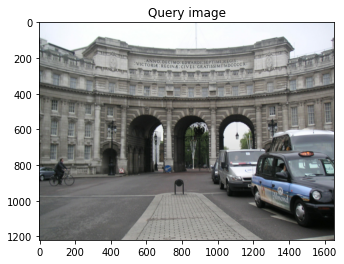

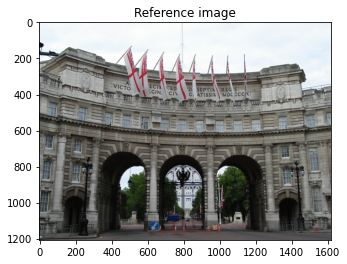

In [13]:
# define the images to match
query_image = imageio.imread('../images/imgs/img_0.jpg', pilmode='RGB')
reference_image = imageio.imread('../images/imgs/img_1.jpg', pilmode='RGB')

# define intrinsic parameters
cam_query = np.load('../images/camera_0.npy', allow_pickle=True).item()
cam_reference = np.load('../images/camera_1.npy', allow_pickle=True).item()
K_query = cam_query['intrinsic']
K_reference = cam_reference['intrinsic']

query_image_shape = query_image.shape
ref_image_shape = reference_image.shape
plt.imshow(query_image)
plt.title('Query image')
plt.show()

plt.imshow(reference_image)
plt.title('Reference image')
plt.show()

# II. Choose the model, and run it to estimate the flow field relating the image pair

In [14]:
print('Possible model types are:')
print(model_type)
print('\nPossible pre-trained model types are:')
print(pre_trained_model_types)

Possible model types are:
['GLUNet', 'GLUNet_interp', 'GLUNet_GOCor', 'PWCNet', 'PWCNet_GOCor', 'GLUNet_GOCor_star', 'PDCNet', 'PDCNet_plus', 'GLUNet_star', 'WarpCGLUNet', 'SemanticGLUNet', 'WarpCSemanticGLUNet', 'WarpCGLUNet_interp', 'SFNet', 'PWarpCSFNet', 'PWarpCSFNet_star', 'NCNet', 'PWarpCNCNet', 'PWarpCNCNet_star', 'CATs', 'PWarpCCATs', 'CATs_ft_features', 'PWarpCCATs_ft_features', 'DHPF', 'PWarpCDHPF']

Possible pre-trained model types are:
['static', 'dynamic', 'chairs_things', 'chairs_things_ft_sintel', 'megadepth', 'megadepth_stage1', 'pfpascal', 'spair']


In [15]:
# choose model 
model = 'PDCNet_plus'
pre_trained_model = 'megadepth'
flipping_condition = False 
global_optim_iter = 3
local_optim_iter = 7 
path_to_pre_trained_models = '/cluster/work/cvl/truongp/DenseMatching/pre_trained_models/' 
    
if model not in model_type:
    raise ValueError('The model that you chose is not valid: {}'.format(model))
if pre_trained_model not in pre_trained_model_types:
    raise ValueError('The pre-trained model type that you chose is not valid: {}'.format(pre_trained_model))


# inference parameters for PDC-Net
network_type = model  # will only use these arguments if the network_type is 'PDCNet' or 'PDCNet_plus'
choices_for_multi_stage_types = ['d', 'h', 'ms']
multi_stage_type = 'h'
if multi_stage_type not in choices_for_multi_stage_types:
    raise ValueError('The inference mode that you chose is not valid: {}'.format(multi_stage_type))

confidence_map_R =1.0
ransac_thresh = 1.0
mask_type = 'proba_interval_1_above_10'  # for internal homo estimation
homography_visibility_mask = True
scaling_factors = [0.5, 0.6, 0.88, 1, 1.33, 1.66, 2]
compute_cyclic_consistency_error = True  # here to compare multiple uncertainty 

# usually from argparse
args = DotDict({'network_type': network_type, 'multi_stage_type': multi_stage_type, 'confidence_map_R': confidence_map_R, 
                'ransac_thresh': ransac_thresh, 'mask_type': mask_type, 
                'homography_visibility_mask': homography_visibility_mask, 'scaling_factors': scaling_factors, 
                'compute_cyclic_consistency_error': compute_cyclic_consistency_error})


In [16]:
# define network and load network weights
network, estimate_uncertainty = select_model(
    model, pre_trained_model, args, global_optim_iter, local_optim_iter,
    path_to_pre_trained_models=path_to_pre_trained_models)
estimate_uncertainty = True  
# here, we overwrite it, to also estimate uncertainty according to forward-backward for networks that do not predict a confidence measure

Model: PDCNet_plus
Pre-trained-model: megadepth
GOCor: Local iter 7
GOCor: Global iter 3


In [17]:
# convert the images to correct format to be processed by the network: torch Tensors, format B, C, H, W. 
# pad both images to the same size, to be processed by network
query_image_, reference_image_ = pad_to_same_shape(query_image, reference_image)
# convert numpy to torch tensor and put it in right format
query_image_ = torch.from_numpy(query_image_).permute(2, 0, 1).unsqueeze(0)
reference_image_ = torch.from_numpy(reference_image_).permute(2, 0, 1).unsqueeze(0)

In [18]:
if estimate_uncertainty:
    estimated_flow, uncertainty_components = network.estimate_flow_and_confidence_map(query_image_, reference_image_)
else:
    if args.flipping_condition and 'GLUNet' in args.model:
        estimated_flow = network.estimate_flow_with_flipping_condition(query_image_, reference_image_,
                                                                       mode='channel_first')
    else:
        estimated_flow = network.estimate_flow(query_image_, reference_image_, mode='channel_first')
# removes the padding
estimated_flow = estimated_flow[:, :, :ref_image_shape[0], :ref_image_shape[1]]

# convert to numpy and reformat
estimated_flow_numpy = estimated_flow.squeeze().permute(1, 2, 0).cpu().numpy()

# warp the query image according to the estimated flow
warped_query_image = remap_using_flow_fields(query_image, estimated_flow_numpy[:, :, 0],
                                             estimated_flow_numpy[:, :, 1]).astype(np.uint8)

## Visualize confidence estimation
Only PDC-Net predicts a confidence value associated with the match (referred to as 'p_r' here). However, other approaches can use the inverse of the forward-backward cyclic consistency as a confidence measure (referred to as 'inv_cyclic_consistency_error' here). You can play around with the different confidence estimation methods and visualize the confident regions as well as top confident matches.  

In [19]:
# confidence estimation + visualization
if not estimate_uncertainty: 
    raise ValueError

print(uncertainty_components.keys())
uncertainty_key = 'p_r'  # 'inv_cyclic_consistency_error' 
#'p_r', 'inv_cyclic_consistency_error' can also be used as a confidence measure
# 'cyclic_consistency_error' can also be used, but that's an uncertainty measure
min_confidence = 0.30
confidence_map = uncertainty_components[uncertainty_key]
confidence_map = confidence_map[:, :, :ref_image_shape[0], :ref_image_shape[1]]

dict_keys(['log_var_map', 'weight_map', 'p_r', 'inference_parameters', 'variance', 'warping_mask', 'cyclic_consistency_error', 'inv_cyclic_consistency_error'])


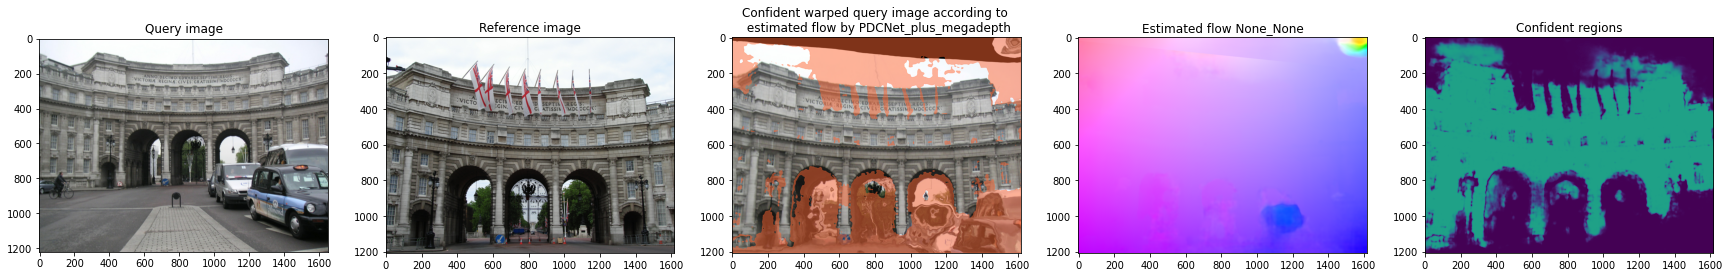

In [20]:
color = [255, 102, 51]
fig, axis = plt.subplots(1, 5, figsize=(30, 30))

confidence_map_numpy = confidence_map.squeeze().detach().cpu().numpy()
confident_mask = (confidence_map_numpy > min_confidence).astype(np.uint8)
confident_warped = overlay_semantic_mask(warped_query_image, ann=255 - confident_mask*255, color=color)
axis[2].imshow(confident_warped)
axis[2].set_title('Confident warped query image according to \n estimated flow by {}_{}'
                  .format(model, pre_trained_model))
axis[4].imshow(confidence_map_numpy, vmin=0.0, vmax=1.0)
axis[4].set_title('Confident regions')

axis[0].imshow(query_image)
axis[0].set_title('Query image')
axis[1].imshow(reference_image)
axis[1].set_title('Reference image')

axis[3].imshow(flow_to_image(estimated_flow_numpy))
axis[3].set_title('Estimated flow {}_{}'.format(args.model, args.pre_trained_model))
fig.show()

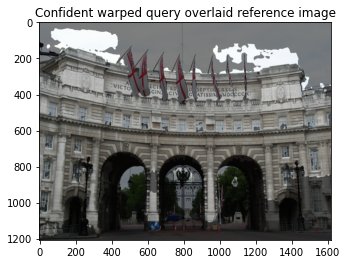

In [21]:
# plot the confident warped regions overlaid on the reference image
alpha=0.5
if estimate_uncertainty:
    img_warped_overlay_on_target_masked = warped_query_image * alpha * np.tile(
        np.expand_dims(confident_mask.astype(np.uint8), axis=2), (1, 1, 3)) + \
         (1 - alpha) * reference_image
else:
    img_warped_overlay_on_target_masked = warped_query_image / 255 * 0.5 + reference_image / 255 * 0.5
plt.imshow(img_warped_overlay_on_target_masked.astype(np.uint8))
plt.title('Confident warped query overlaid reference image')
plt.show()

# III. Identify confident matches to use for pose estimation and compute the pose

Choose which mask type, either cyclic consistency error below some value or proba_interval_above something. 

In [22]:
# get the mask according to uncertainty estimation
mask_type = 'proba_interval_1_above_10' # 'cyclic_consistency_error_below_2' 
#'proba_interval_1_above_10' can be used in association with all networks, relying on p_r for PDC-Net 
# and inv_cyclic_consistency_error for the other networks
# Alternatively, can use instead 'cyclic_consistency_error_below_x'
# choices_for_mask_type = ['cyclic_consistency_error_below_x', 'x_percent_most_certain', 'variance_below_x', 
#                          'proba_interval_z_above_x_NMS_y',  'proba_interval_z_above_x_grid_y', 
#                          'proba_interval_z_above_x']  x, y and z are numbers to choose

###  Alternative 1: Compute the matches at full resolution (will be MANY matches)
It means just select the confident matches from the full resolution flow field previously estimated. 


In [23]:
mask_padded = estimate_mask(mask_type, uncertainty_components) 
if 'warping_mask' in list(uncertainty_components.keys()):
    # get mask from internal multi stage alignment, if it took place
    mask_padded = uncertainty_components['warping_mask'] * mask_padded

# remove the padding
mask = mask_padded[:, :ref_image_shape[0], :ref_image_shape[1]]

# remove point that lead to outside the query image
mapping_estimated = convert_flow_to_mapping(estimated_flow)
mask = mask & mapping_estimated[:, 0].ge(0) & mapping_estimated[:, 1].ge(0) & \
mapping_estimated[:, 0].le(query_image_shape[1] - 1) & mapping_estimated[:, 1].le(query_image_shape[0] - 1)

mkpts_query, mkpts_ref = matches_from_flow(estimated_flow, mask)

#### Plot the confident matches used for pose estimation

Found 1167286 confident matches


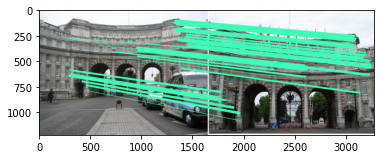

In [24]:
print('Found {} confident matches'.format(len(mkpts_query)))

confidence_values = confidence_map.squeeze()[mask.squeeze()].cpu().numpy()
sort_index = np.argsort(np.array(confidence_values)).tolist()[::-1]  # from highest to smallest
confidence_values = np.array(confidence_values)[sort_index]
mkpts_query = np.array(mkpts_query)[sort_index]
mkpts_ref = np.array(mkpts_ref)[sort_index]

if len(mkpts_query) < 5:
    mkpts_query = np.empty([0, 2], dtype=np.float32)
    mkpts_ref = np.empty([0, 2], dtype=np.float32)
    confidence_values = np.empty([0], dtype=np.float32)

# plot top 10000
k_top = 10000
mkpts_q = mkpts_query[:k_top]
mkpts_r = mkpts_ref[:k_top]
confidence_values = confidence_values[:k_top]
color = cm.jet(confidence_values)
out = make_sparse_matching_plot(query_image, reference_image, mkpts_q, mkpts_r, color, margin=10)

plt.imshow(out)
plt.show()

### Alternative 2: Compute the matches at 1/4 of the image resolution (actual output of the network), select the confident ones and just scale them to original image resolution

In [25]:
# all the previous steps are already embedded in this function. 
output = network.get_matches_and_confidence(query_image_, reference_image_)
mkpts_query = output['kp_source']
mkpts_ref = output['kp_target']
confidence_values = output['confidence_value']

#### plot the confident matches used for pose estimation

Found 72970 confident matches


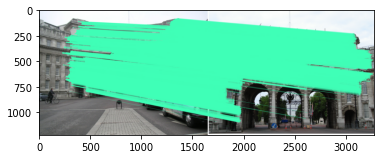

In [26]:
print('Found {} confident matches'.format(len(mkpts_query)))

sort_index = np.argsort(np.array(confidence_values)).tolist()[::-1]  # from highest to smallest
confidence_values = np.array(confidence_values)[sort_index]
mkpts_query = np.array(mkpts_query)[sort_index]
mkpts_ref = np.array(mkpts_ref)[sort_index]

if len(mkpts_query) < 5:
    mkpts_query = np.empty([0, 2], dtype=np.float32)
    mkpts_ref = np.empty([0, 2], dtype=np.float32)
    confidence_values = np.empty([0], dtype=np.float32)
    
# plot top 10000
k_top = 10000
mkpts_q = mkpts_query[:k_top]
mkpts_r = mkpts_ref[:k_top]
confidence_values = confidence_values[:k_top]
color = cm.jet(confidence_values)
out = make_sparse_matching_plot(query_image, reference_image, mkpts_q, mkpts_r, color, margin=10)

plt.imshow(out)
plt.show()

### Actual relative 
pose estimation code

In [27]:
print('Computing the relative pose from {} correspondences'.format(len(mkpts_query)))
thresh = 1.0  # In pixels relative to resized image load_size.
# relative pose from query to reference
ret = estimate_pose(mkpts_query, mkpts_ref, K_query, K_reference, ransac=True, thresh=thresh)
if ret is not None:
    (R, t, mask_inlier) = ret
print('Estimated pose:')
print('Rotation:')
print(R)

print('Translation:')
print(t)

Computing the relative pose from 72970 correspondences
Estimated pose:
Rotation:
[[ 0.98856411 -0.02044575 -0.14940872]
 [ 0.03938437  0.99138462  0.12492157]
 [ 0.14556739 -0.12937734  0.98085251]]
Translation:
[ 0.74216195 -0.12489759 -0.65848024]


## If ground-truth relative pose is available, check the results

In [28]:
from validation.utils import compute_pose_error

cam_w_to_query = np.linalg.inv(cam_query['c2w'])
cam_w_to_ref = np.linalg.inv(cam_reference['c2w'])
cam_query_to_ref = cam_w_to_ref @ np.linalg.inv(cam_w_to_query)

if ret is None:
    err_t, err_R = np.inf, np.inf
else:
    R, t, inliers = ret
    err_t, err_R = compute_pose_error(cam_query_to_ref, R, t)

print('Error is {}'.format(max(err_t, err_R)))

Error is 6.123684114806637


# IV. Triangulate the corresponding 3D points

In [29]:
import validation.compute_point_cloud as pc

# normalize image coordinates
norm_pts_query = (mkpts_query - K_query[[0, 1], [2, 2]][None]) / K_query[[0, 1], [0, 1]][None]
norm_pts_ref = (mkpts_ref - K_reference[[0, 1], [2, 2]][None]) / K_reference[[0, 1], [0, 1]][None]

'''
if use_inliers_of_essentiel_ransac:
    if mask is not None:
        norm_pts1 = norm_pts1[mask]
        norm_pts2 = norm_pts2[mask]
        pts1 = pts1[mask]
        pts2 = pts2[mask]
'''

# do triangulation to obtain the 3D points corresponding to the matches between the images
coords = pc.compute_3D_pos(norm_pts_query, norm_pts_ref, R, t.reshape(-1, 1))

# get the RGB colors of the points
colors = pc.get_point_cloud_color(query_image, reference_image, mkpts_query, mkpts_ref, by_path=False)

# Depending on the machine, plot the 3D reconstruction. 
'''    

import trimesh 

mesh = trimesh.Trimesh(
    vertices=coords,
    vertex_colors=colors
)          
mesh.export(os.path.join(savepath,   "mesh_{}.ply".format(suffix)))  
'''   

'''
import pyrender
import os
import open3d as o3d
os.environ["PYOPENGL_PLATFORM"] = "egl" #opengl seems to only work with TPU
!PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"
print(os.environ['PYOPENGL_PLATFORM']) 
import OpenGL.GL as gl
print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd])
'''


'\nimport pyrender\nimport os\nimport open3d as o3d\nos.environ["PYOPENGL_PLATFORM"] = "egl" #opengl seems to only work with TPU\n!PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"\nprint(os.environ[\'PYOPENGL_PLATFORM\']) \nimport OpenGL.GL as gl\nprint(gl.glGetString(gl.GL_VERSION))\nprint(gl.glGetString(gl.GL_VENDOR)) \npcd = o3d.geometry.PointCloud()\npcd.points = o3d.utility.Vector3dVector(points)\npcd.colors = o3d.utility.Vector3dVector(colors)\no3d.visualization.draw_geometries([pcd])\n'